In [40]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.decomposition import PCA, RandomizedPCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("paper")
#from PIL import Image

(from Data Science for business: Foster and Fawcwett:)

The "posterior expected loss" sets us up very nicely to evaluate classifiers based on the notion that out losses or gains should reflect our business scenario. (Note that we could have as well maximized utility or benefit instead of minimizing loss. Its the same formula.


![expectedvalue](https://dl.dropboxusercontent.com/u/75194/expectedvalue.png)

### ROC Curve

Let $p(y=1|x) > t$ mean $g(x)=1$. $t$ is the threshold. We move it from 0 to 1 and get different TPR and FPR and plot TPR against FPR.

$$TPR = Recall = \frac{TP}{ObsvP} = \frac{TP}{TP+FN}.$$

$$FPR = \frac{FP}{ObsvN} = \frac{FP}{FP+TN}$$

![howto roc](https://dl.dropboxusercontent.com/u/75194/howtoroc.png)

In [17]:
fprhw, tprhw, thresholdshw=roc_curve(resutest, dflogis.predict_proba(dftest)[:,1])
roc_auchw = auc(fprhw, tprhw)

In [18]:
print thresholdshw

[  9.99996090e-01   9.99995039e-01   9.99992241e-01 ...,   2.82408442e-05
   2.48731761e-05   1.91550691e-05]


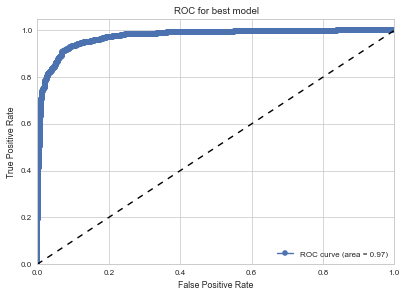

In [19]:
plt.plot(fprhw, tprhw, 'o-', label='ROC curve (area = %0.2f)' % roc_auchw)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right");

### Precision and Recall

**Recall** tells you how many of the true positives were recalled:

$$Recall = \frac{TP}{ObsvP} = \frac{TP}{TP+FN}.$$

**Precision** tells you how many of the returned hits (+ives) were truly positive

$$Precision = \frac{TP}{PredP} = \frac{TP}{TP+FP}.$$

[ 0.55778622  0.55754615  0.557849   ...,  1.          1.          1.        ] [  1.00000000e+00   9.99027237e-01   9.99027237e-01 ...,   1.94552529e-03
   9.72762646e-04   0.00000000e+00] [ 0.00172081  0.00174447  0.00177031 ...,  0.99999224  0.99999504
  0.99999609]


(0.0, 1.05)

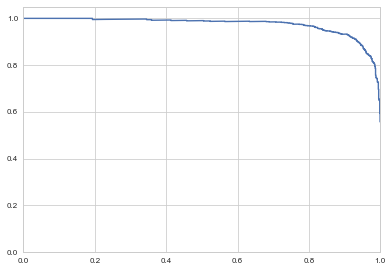

In [98]:
phw,rhw,thw = precision_recall_curve(resutest, dflogis.predict_proba(dftest)[:,1])
print phw, rhw, thw
plt.plot(rhw, phw);
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

### The ATM Camera example

In [7]:
data=np.load("../Data/imag.pix.npy")
y=np.load("../Data/imag.lbl.npy")
STANDARD_SIZE = (322, 137)
data.shape, y.shape

((87, 132342), (87,))

In [8]:
def get_image(mat):
    size = STANDARD_SIZE[0]*STANDARD_SIZE[1]*3
    r,g,b = mat[0:size:3], mat[1:size:3],mat[2:size:3]
    rgbArray = np.zeros((137,322,3), 'uint8')
    rgbArray[..., 0] = r.reshape((STANDARD_SIZE[1], STANDARD_SIZE[0]))
    rgbArray[..., 1] = b.reshape((STANDARD_SIZE[1], STANDARD_SIZE[0]))
    rgbArray[..., 2] = g.reshape((STANDARD_SIZE[1], STANDARD_SIZE[0]))
    return rgbArray

def display_image(mat):
    with sns.axes_style("white"):
        plt.imshow(get_image(mat))
        plt.xticks([])
        plt.yticks([])

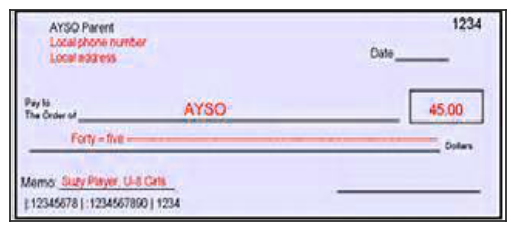

In [9]:
display_image(data[5])

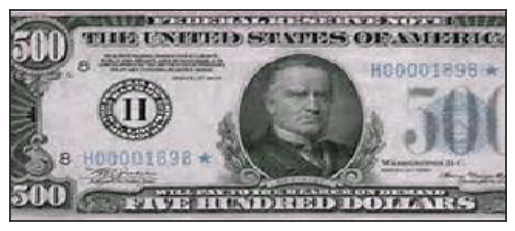

In [10]:
display_image(data[50])

### The curse of dimensionality: Feature engineering

In [14]:
pca = PCA(n_components=50)
X = pca.fit_transform(data)
print(pca.explained_variance_ratio_.sum())

0.905024032618


In [15]:
pca.explained_variance_ratio_

array([ 0.35925967,  0.06293188,  0.04107783,  0.0311951 ,  0.0281696 ,
        0.02288316,  0.02101279,  0.0187405 ,  0.01732646,  0.01530237,
        0.01421596,  0.0131839 ,  0.01247012,  0.01163814,  0.01099558,
        0.01060721,  0.01007427,  0.00980139,  0.00960547,  0.00915279,
        0.00901757,  0.00852039,  0.00836557,  0.00796719,  0.00754596,
        0.00724595,  0.00707508,  0.00679543,  0.00660069,  0.00647247,
        0.00625879,  0.005943  ,  0.00579477,  0.00573989,  0.00568235,
        0.00551659,  0.00536955,  0.00531699,  0.00512958,  0.0049085 ,
        0.00478072,  0.00471714,  0.00468166,  0.00450594,  0.00438156,
        0.00435184,  0.00430981,  0.00424744,  0.00413123,  0.00400619])

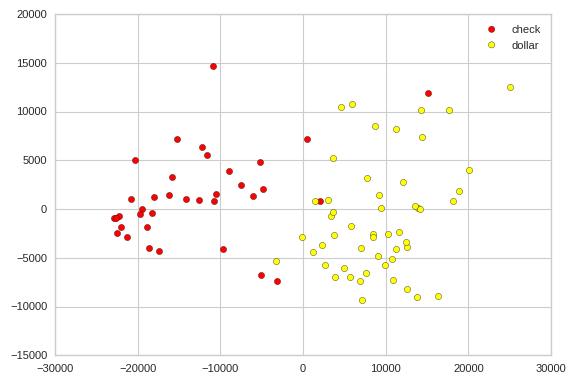

In [16]:
df = pd.DataFrame({"pc1": X[:, 0], "pc2": X[:, 1], "y":y, "label":np.where(y==1, "check", "dollar")})
colors = ["red", "yellow"]
for label, color in zip(df['label'].unique(), colors):
    mask = df['label']==label
    plt.scatter(df[mask]['pc1'], df[mask]['pc2'], c=color, label=label)
plt.legend()

In [17]:
def normit(a):
    a=(a - a.min())/(a.max() -a.min())
    a=a*256
    return np.round(a)
def getNC(pc, j):
    size=322*137*3
    r=pc.components_[j][0:size:3]
    g=pc.components_[j][1:size:3]
    b=pc.components_[j][2:size:3]
    r=normit(r)
    g=normit(g)
    b=normit(b)
    return r,g,b
def display_component(pc, j):
    r,g,b = getNC(pc,j)
    rgbArray = np.zeros((137,322,3), 'uint8')
    rgbArray[..., 0] = r.reshape(137,322)
    rgbArray[..., 1] = g.reshape(137,322)
    rgbArray[..., 2] = b.reshape(137,322)
    plt.imshow(rgbArray)
    plt.xticks([])
    plt.yticks([])

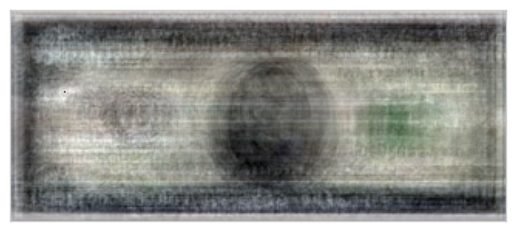

In [18]:
display_component(pca,0)

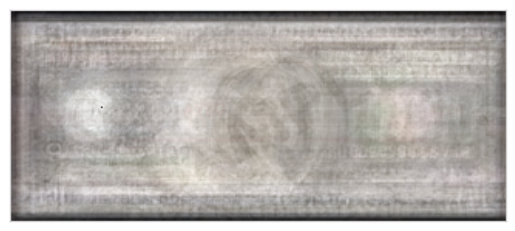

In [19]:
display_component(pca,1)

### Classifying in a reduced feature space with kNN

In [29]:
ys=df['y'].astype(int).values
subdf=df[['pc1','pc2']]
subdfstd=(subdf - subdf.mean())/subdf.std()
Xs=subdfstd.values

def classify(X,y, nbrs, plotit=True, train_size=0.6):
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=train_size)
    clf= KNeighborsClassifier(nbrs)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    Xall=np.concatenate((Xtrain, Xtest))
    if plotit:
        print("Accuracy on training data: %0.2f" % (training_accuracy))
        print("Accuracy on test data:     %0.2f" % (test_accuracy))
        #points_plot2(Xall, Xtrain, Xtest, ytrain, ytest, clf)
    return nbrs, training_accuracy, test_accuracy

In [30]:
classify(Xs,ys,1)

Accuracy on training data: 1.00
Accuracy on test data:     0.94


(1, 1.0, 0.94285714285714284)

In [31]:
classify(Xs,ys,40)#run this a few times

Accuracy on training data: 0.63
Accuracy on test data:     0.60


(40, 0.63461538461538458, 0.59999999999999998)

In [32]:
classify(Xs,ys,17)

Accuracy on training data: 0.94
Accuracy on test data:     0.91


(17, 0.94230769230769229, 0.91428571428571426)

### Learning Curves (against complexity)

In [33]:
fits={}
for k in np.arange(1,40,1):
    fits[k]=[]
    for i in range(200):
        fits[k].append(classify(Xs, ys,k, False))
nbrs=np.arange(1,40,1)
fmeanstr = np.array([1.-np.mean([t[1] for t in fits[e]]) for e in nbrs])
fmeanste = np.array([1.-np.mean([t[2] for t in fits[e]]) for e in nbrs])
fstdsstr = np.array([np.std([t[1] for t in fits[e]]) for e in nbrs])
fstdsste = np.array([np.std([t[2] for t in fits[e]]) for e in nbrs])

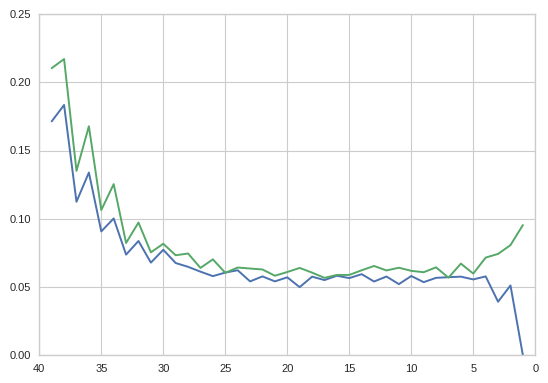

In [34]:
pal=sns.color_palette()
plt.gca().invert_xaxis()
plt.plot(nbrs, fmeanstr, color=pal[0]);

plt.plot(nbrs, fmeanste, color=pal[1]);

In [41]:
def cv_optimize_knn(X, y, n_folds=10):
    clf = KNeighborsClassifier()
    parameters = {"n_neighbors": range(1,40,1)}
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(X, y)
    return gs

In [42]:
Xtrain, Xtest, ytrain, ytest = train_test_split(Xs, ys, train_size=0.8)
bestcv = cv_optimize_knn(Xtrain, ytrain)

In [43]:
bestcv.best_estimator_, bestcv.best_params_, bestcv.best_score_

(KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=None, n_jobs=1, n_neighbors=3, p=2,
            weights='uniform'), {'n_neighbors': 3}, 0.94202898550724634)

### Callibration and Evaluation

In [46]:
confusion_matrix(bestcv.predict(Xtest), ytest)

array([[9, 1],
       [0, 8]])

In [48]:
print(classification_report(bestcv.predict(Xtest), ytest))

             precision    recall  f1-score   support

          0       1.00      0.90      0.95        10
          1       0.89      1.00      0.94         8

avg / total       0.95      0.94      0.94        18



### Changing the risk function

What if the risk is asymmetric? What if the classes are assymetric? Will we do better than the base rate?

(from Data Science for business: Foster and Fawcwett:)

![abmodelcm](https://dl.dropboxusercontent.com/u/75194/abmodelcm.png)

![abmodeldiag](https://dl.dropboxusercontent.com/u/75194/abmodeldiag.png)


We can work out the math for a 2-class problem with assymmetric weights.

At each $x$, or sample:

$$R(1|x) = r_1 = l_{11} p_1 + l_{10} p_0$$

$$R(0|x) = r_0 = l_{01} p_1 + l_{00} p_0$$

We decide $g=1$ if $r_1 < r_0$ else we decide g=0. If the assymetric losses are 0 then this works out to; choose 1 iff:

$$p_0 < r p_1$$

where

$$r = \frac{l_{01}}{l_{10}} = \frac{l_{FN}}{l_{FP}}$$

In [64]:
def points_plot_asymm(X, Xtr, Xte, ytr, yte, clf, r):
    h = .02
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    plt.figure(figsize=(10,6))
    p0 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
    p1 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = p0 < r*p1

    #Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.pcolormesh(xx, yy, Z, alpha=0.2)
    plt.scatter(Xtr[:, 0], Xtr[:, 1], c=ytr-1, s=50, alpha=0.2,edgecolor="k")
    # and testing points
    yact=clf.predict(Xte)
    plt.scatter(Xte[:, 0], Xte[:, 1], c=yte-1, alpha=0.5, marker="s", s=35)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    return plt.gca()

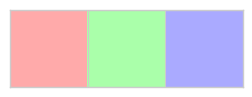

In [60]:
sns.palplot(['#FFAAAA', '#AAFFAA', '#AAAAFF'])

In [61]:
def make_myscorer(r):
    def my_scorer(est, X, y):
        probs=est.predict_proba(X)
        p0 = probs[:,0]
        p1 = probs[:,1]
        ypred = (p0 < r*p1)*1
        return recall_score(y, ypred)
    return my_scorer

def cv_optimize_knn_ASYMM(X, y, k, n_folds=10):
    clf = KNeighborsClassifier()
    parameters = {"n_neighbors": range(1,40,1)}
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, scoring=make_myscorer(k))
    gs.fit(X, y)
    return gs


In [62]:
bestcv2 = cv_optimize_knn_ASYMM(Xtrain, ytrain, 10)
bestcv2.best_estimator_, bestcv2.best_params_, bestcv2.best_score_

(KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=None, n_jobs=1, n_neighbors=11, p=2,
            weights='uniform'), {'n_neighbors': 11}, 1.0)

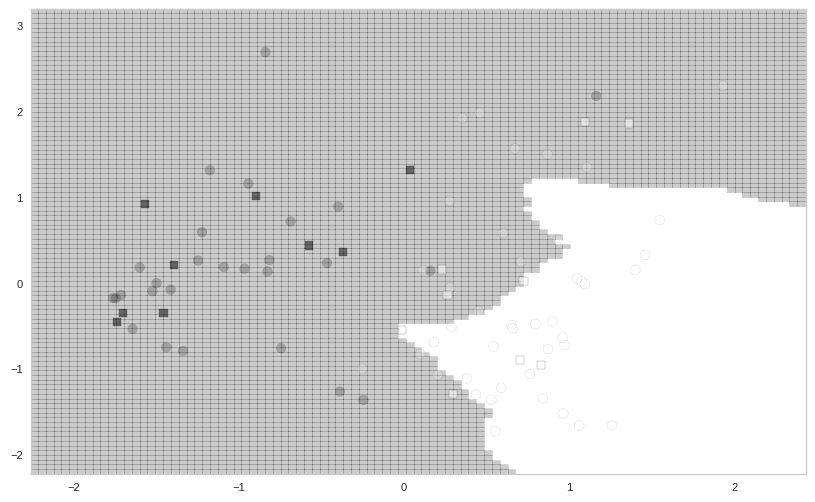

In [65]:
points_plot_asymm(Xs, Xtrain, Xtest, ytrain, ytest, bestcv2, 10)

In [66]:
def repredict(est,r, xtest):
    probs=est.predict_proba(xtest)
    p0 = probs[:,0]
    p1 = probs[:,1]
    ypred = (p0 < r*p1)*1
    return ypred

In [67]:
confusion_matrix(ytest, repredict(bestcv2, 10, Xtest))

array([[4, 5],
       [0, 9]])

In [72]:
def points_plot_asymm3(X, Xtr, Xte, ytr, yte, clf, k0, k1):
    h = .02
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    plt.figure(figsize=(10,6))
    p0 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
    p1 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    zpred1 = (k1 < p1)*1
    zpred2 = (k0 < p1)*1
    Z =  zpred1 + zpred2
    #Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.pcolormesh(xx, yy, Z, alpha=0.2)
    plt.scatter(Xtr[:, 0], Xtr[:, 1], c=ytr-1, s=50, alpha=0.2,edgecolor="k")
    # and testing points
    yact=clf.predict(Xte)
    plt.scatter(Xte[:, 0], Xte[:, 1], c=yte-1, alpha=0.8, marker="s", s=35)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    return plt.gca()

### The reject option

Yet another way to think about this is to leave stuff inbetween the two classes to a human: just classify it into a third class. I'll leave the loss function formalism for you to develop.

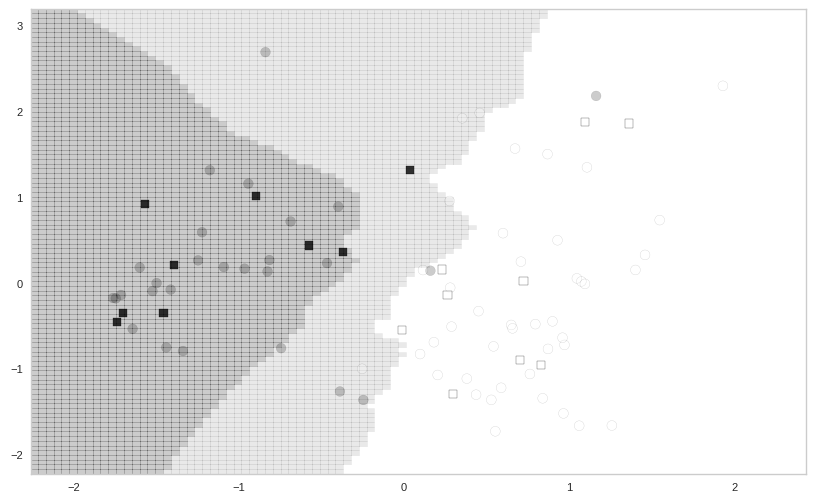

In [73]:
points_plot_asymm3(Xs, Xtrain, Xtest, ytrain, ytest, bestcv2, 0.25, 0.75)

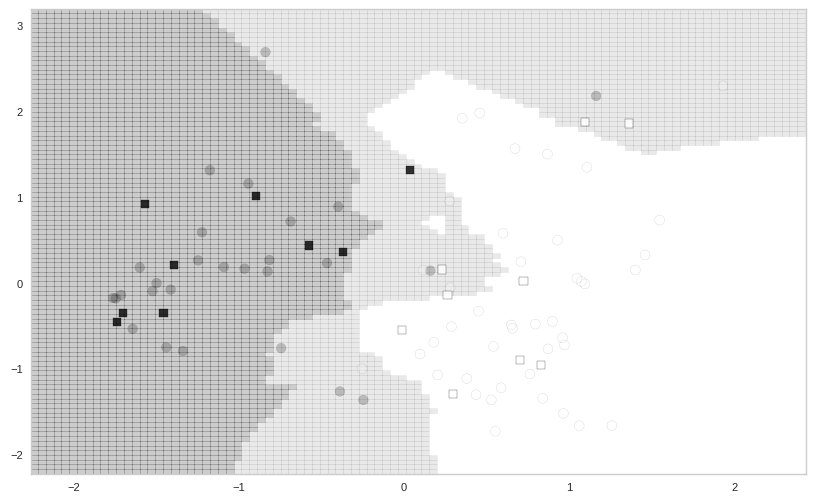

In [74]:
points_plot_asymm3(Xs, Xtrain, Xtest, ytrain, ytest, bestcv, 0.25, 0.75)

###More model evaluation and comparison

Did you do better than random? Did you do better than the base rate?

In [75]:
fpr, tpr, thresholds=roc_curve(ytest, bestcv.predict_proba(Xtest)[:,1])

In [76]:
roc_auc = auc(fpr, tpr)

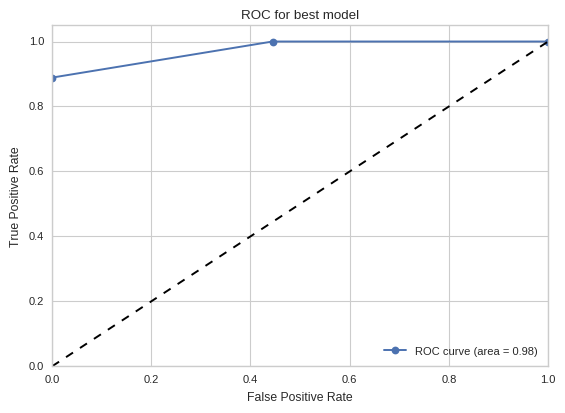

In [77]:
plt.plot(fpr, tpr, 'o-', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for best model')
plt.legend(loc="lower right");

In [79]:
print(classification_report(ytest, bestcv.predict(Xtest)))

             precision    recall  f1-score   support

          0       0.90      1.00      0.95         9
          1       1.00      0.89      0.94         9

avg / total       0.95      0.94      0.94        18



In [81]:
print(classification_report(ytest, repredict(bestcv2, 10, Xtest)))

             precision    recall  f1-score   support

          0       1.00      0.44      0.62         9
          1       0.64      1.00      0.78         9

avg / total       0.82      0.72      0.70        18

